<a href="https://colab.research.google.com/github/khagerthey/GIS/blob/main/PS1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#My Plan
I plan on focusing my research around entrepreneurship. I feel with the useful tool of social media there has been an increase in small businesses. I’m interested in seeing how location within the United States has an effect on the type of businesses, location of buyer vs seller, and correlation between business and local cost of living.

#Resources
https://www.statista.com/statistics/1306812/number-us-etsy-sellers-state/
Here is usable data of the number of sellers in each state! (2021)

https://www.marketplacepulse.com/top-etsy-sellers
Here is usable data of top Etsy sellers! (countries)

US States shapefile link: https://www.sciencebase.gov/catalog/item/52c78623e4b060b9ebca5be5

2023 State population table link:
https://worldpopulationreview.com/states

In [7]:
import os, zipfile
import pandas as pd
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from google.colab import data_table
data_table.enable_dataframe_formatter()

import geopandas as gpd
from shapely.geometry import Point
%matplotlib inline
!pip install mapclassify
import mapclassify

#Working with Data

##Merge

I am using the 2022 state's population to compare to the 2021 Etsy Seller US population. My hypothesis is that there is a direct correlation between populations. This is a good place to start to try and determine what drives small business success. I'm thinking more people in one location means more potential buyers.

In [144]:
state_population_raw=pd.read_csv('https://raw.githubusercontent.com/khagerthey/GIS/main/state-population-table.csv')
state_population_columns = state_population_raw[['state', 'pop2022']]
state_population = state_population_columns.rename(columns={'pop2022': 'Total Population 2022 in Millions', 'state': 'US State'})
district_of_columbia = pd.DataFrame({'US State': ['District of Columbia'], 'Total Population 2022 in Millions': [671803.0]})
puerto_rico = pd.DataFrame({'US State': ['Puerto Rico'], 'Total Population 2022 in Millions': [3221789.0]})
combined_states = pd.concat([state_population, district_of_columbia, puerto_rico], ignore_index=True)

combined_states['Total Population 2022 in Millions'] = combined_states['Total Population 2022 in Millions']/ 100000
combined_states['Total Population 2022 in Millions'] = combined_states['Total Population 2022 in Millions'].round(1)

combined_states

,US State,Total Population 2022 in Millions
0,California,390.3
1,Texas,300.3
2,Florida,222.4
3,New York,196.8
4,Pennsylvania,129.7
5,Illinois,125.8
6,Ohio,117.6
7,Georgia,109.1
8,North Carolina,107.0
9,Michigan,100.3


In [86]:
etsy_us_sellers=pd.read_csv('https://raw.githubusercontent.com/khagerthey/GIS/main/etsy_statessellerstats.csv', header=None)
etsy_us_sellers.columns=["US State", "Etsy Sellers in Thousands 2021"]
etsy_sellers = etsy_us_sellers.replace('Washington, D.C.', 'District of Columbia')
etsy_sellers

,US State,Etsy Sellers in Thousands 2021
0,California,465.6
1,Texas,337.3
2,Florida,302.4
3,New York,251.5
4,Pennsylvania,143.3
5,Illinois,133.9
6,Michigan,130.2
7,Ohio,130.1
8,Georgia,128.5
9,North Carolina,123.3


In [145]:
state_seller_compare = pd.merge(combined_states, etsy_sellers, how='outer', on=['US State'], indicator='true')
state_seller_compare
#everything merged correctly

,US State,Total Population 2022 in Millions,Etsy Sellers in Thousands 2021,true
0,California,390.3,465.6,both
1,Texas,300.3,337.3,both
2,Florida,222.4,302.4,both
3,New York,196.8,251.5,both
4,Pennsylvania,129.7,143.3,both
5,Illinois,125.8,133.9,both
6,Ohio,117.6,130.1,both
7,Georgia,109.1,128.5,both
8,North Carolina,107.0,123.3,both
9,Michigan,100.3,130.2,both


We can see from the table that population aligns with sellers.

##Map data

In [75]:
#shapefile of US map states
! wget -q -O cb_2018_us_state_5m.zip https://github.com/khagerthey/GIS/raw/main/cb_2018_us_state_5m.zip


(-127.0, -66.0)

(25.0, 50.0)

<ipython-input-146-bec66680139a>:8: FutureWarning: In a future version of pandas all arguments of DataFrame.set_index except for the argument 'keys' will be keyword-only.
  continental_map_data =states_map.join(state_seller_compare.set_index("US State", "Total Population 2022 in Millions"), on="NAME")


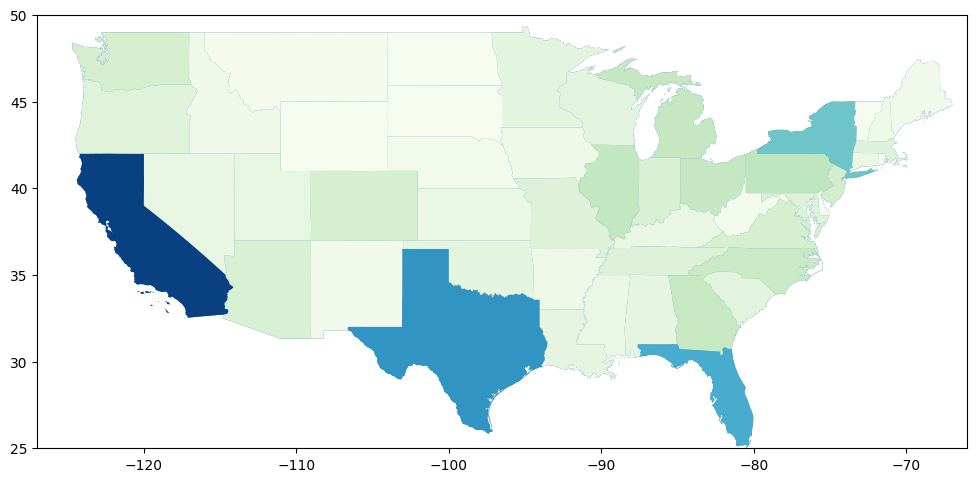

In [146]:
zip_ref = zipfile.ZipFile('cb_2018_us_state_5m.zip', 'r'); zip_ref.extractall(); zip_ref.close() #unzipping
states_map = gpd.read_file('cb_2018_us_state_5m.shp')

ax = states_map.plot(figsize = (12,12))
ax.set_xlim(-127, -66)
ax.set_ylim(25, 50)

continental_map_data =states_map.join(state_seller_compare.set_index("US State", "Total Population 2022 in Millions"), on="NAME")
new_map = continental_map_data.plot(column="Etsy Sellers in Thousands 2021", cmap="GnBu", ax=ax)

#plan to focus on only continental US for right now

As perdicted, can see a direct link. I don't think this map best displays that link tho.

US states map will be used to input the data above. This will visualize the amount of sellers in each state within the US. After visualizing, the next step will to deeper research as to why specific states have a much higher amount.

To do:

- I want a better us states map to use (closer up)

- need to decide on second dataset for the merge
    - refer to google doc

- place data on map